In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import time
from sklearn.decomposition import PCA
from numpy import linalg as LA
from tqdm import tqdm
from IPython import display
%matplotlib inline
import pylab as pl

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [10]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [11]:
pro_s1d1_raw = pro_s1d1.X.toarray()
pro_s1d2_raw = pro_s1d2.X.toarray()
pro_s1d3_raw = pro_s1d3.X.toarray()
pro_s2d1_raw = pro_s2d1.X.toarray()
pro_s2d4_raw = pro_s2d4.X.toarray()
pro_s2d5_raw = pro_s2d5.X.toarray()

pro_s3d1_raw = pro_s3d1.X.toarray()
pro_s3d6_raw = pro_s3d6.X.toarray()
pro_s3d7_raw = pro_s3d7.X.toarray()

pro_s4d1_raw = pro_s4d1.X.toarray()
pro_s4d8_raw = pro_s4d8.X.toarray()
pro_s4d9_raw = pro_s4d9.X.toarray()

In [12]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [13]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, 4)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(4, input_feature+1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)

    def forward(self, x):
        x = self.linear1(x)
        emb = self.relu(x)
        
        output = self.linear5(emb)
        
        return output.float(), emb

In [14]:
def fit(num_epochs, model, loss_fn, RNA, pro, train_batch_name, train_index, feature, ax):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []

    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred, emb = model(x)
            loss_emb = loss_fn(pred[:, :-1], y[:, :-1])
            loss_pro = loss_fn(pred[:, -1], y[:, -1])
            loss = loss_pro + 2*(loss_pro-loss_emb)**2
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch == 999:
            model = model.eval()

            losses_total_temp = []
            losses_encoder_temp = []
            losses_pro_temp = []

            for k in range(len(RNA_batches)):
                pred, emb = model(RNA_batches[k])
                loss_encoder = torch.sqrt(loss_fn(pred[:, :-1], pro_batches[k][:, :-1])).cpu().detach().numpy()
                loss_pro = torch.sqrt(loss_fn(pred[:, -1], pro_batches[k][:, -1])).cpu().detach().numpy()
                loss_total = loss_pro + loss_encoder

                losses_total[train_index, feature, k] = loss_total
                losses_encoder[train_index, feature, k] = loss_encoder
                losses_pro[train_index, feature, k] = loss_pro
                
                if k >= 9 or k == train_index:
                    ax[train_index].scatter(pro_batches[k][:, -1].cpu().detach().numpy(), pred[:, -1].cpu().detach().numpy(), alpha = 0.1, vmin = 0, vmax = 1, label = 'test_' + str(k))
                    ax[train_index].plot([0, 4.2], [0, 4.2], 'k-')
                    ax[train_index].set_title(f'Train {train_index} Protein {feature}')
                    ax[train_index].set_xlabel(f'True values')
                    ax[train_index].set_ylabel(f'Prediction')
                    ax[train_index].set_xlim([0, 4.2])
                    ax[train_index].set_ylim([0, 4.2])
                    ax[train_index].legend()
                
            if train_index == 8:
                ax[train_index+1].imshow(losses_pro[:, feature, :], vmin = 0, vmax = 1)
                ax[train_index+1].set_title(f'Prediction loss of Protein {feature}')
                ax[train_index+1].set_xlabel(f'Test batch')
                ax[train_index+1].set_ylabel(f'Train batch')
                
                ax[train_index+2].imshow(losses_encoder[:, feature, :], vmin = 0, vmax = 1)
                ax[train_index+2].set_title(f'Prediction loss of Protein {feature}')
                ax[train_index+2].set_xlabel(f'Test batch')
                ax[train_index+2].set_ylabel(f'Train batch')
    return

In [15]:
RNA_s1d1_torch = torch.from_numpy(RNA_s1d1)
RNA_s1d2_torch = torch.from_numpy(RNA_s1d2)
RNA_s1d3_torch = torch.from_numpy(RNA_s1d3)
RNA_s2d1_torch = torch.from_numpy(RNA_s2d1)
RNA_s2d4_torch = torch.from_numpy(RNA_s2d4)
RNA_s2d5_torch = torch.from_numpy(RNA_s2d5)
RNA_s3d1_torch = torch.from_numpy(RNA_s3d1)
RNA_s3d6_torch = torch.from_numpy(RNA_s3d6)
RNA_s3d7_torch = torch.from_numpy(RNA_s3d7)
RNA_s4d1_torch = torch.from_numpy(RNA_s4d1)
RNA_s4d8_torch = torch.from_numpy(RNA_s4d8)
RNA_s4d9_torch = torch.from_numpy(RNA_s4d9)

pro_s1d1_torch = torch.from_numpy(pro_s1d1_raw)
pro_s1d2_torch = torch.from_numpy(pro_s1d2_raw)
pro_s1d3_torch = torch.from_numpy(pro_s1d3_raw)
pro_s2d1_torch = torch.from_numpy(pro_s2d1_raw)
pro_s2d4_torch = torch.from_numpy(pro_s2d4_raw)
pro_s2d5_torch = torch.from_numpy(pro_s2d5_raw)
pro_s3d1_torch = torch.from_numpy(pro_s3d1_raw)
pro_s3d6_torch = torch.from_numpy(pro_s3d6_raw)
pro_s3d7_torch = torch.from_numpy(pro_s3d7_raw)
pro_s4d1_torch = torch.from_numpy(pro_s4d1_raw)
pro_s4d8_torch = torch.from_numpy(pro_s4d8_raw)
pro_s4d9_torch = torch.from_numpy(pro_s4d9_raw)

In [16]:
RNA_s1d1_raw_torch = RNA_s1d1_torch.float()
RNA_s1d2_raw_torch = RNA_s1d2_torch.float()
RNA_s1d3_raw_torch = RNA_s1d3_torch.float()
RNA_s2d1_raw_torch = RNA_s2d1_torch.float()
RNA_s2d4_raw_torch = RNA_s2d4_torch.float()
RNA_s2d5_raw_torch = RNA_s2d5_torch.float()
RNA_s3d1_raw_torch = RNA_s3d1_torch.float()
RNA_s3d6_raw_torch = RNA_s3d6_torch.float()
RNA_s3d7_raw_torch = RNA_s3d7_torch.float()
RNA_s4d1_raw_torch = RNA_s4d1_torch.float()
RNA_s4d8_raw_torch = RNA_s4d8_torch.float()
RNA_s4d9_raw_torch = RNA_s4d9_torch.float()

pro_s1d1_torch = pro_s1d1_torch.float()
pro_s1d2_torch = pro_s1d2_torch.float()
pro_s1d3_torch = pro_s1d3_torch.float()
pro_s2d1_torch = pro_s2d1_torch.float()
pro_s2d4_torch = pro_s2d4_torch.float()
pro_s2d5_torch = pro_s2d5_torch.float()
pro_s3d1_torch = pro_s3d1_torch.float()
pro_s3d6_torch = pro_s3d6_torch.float()
pro_s3d7_torch = pro_s3d7_torch.float()
pro_s4d1_torch = pro_s4d1_torch.float()
pro_s4d8_torch = pro_s4d8_torch.float()
pro_s4d9_torch = pro_s4d9_torch.float()

In [17]:
RNA_s1d1_raw_torch = RNA_s1d1_raw_torch.to(device)
RNA_s1d2_raw_torch = RNA_s1d2_raw_torch.to(device)
RNA_s1d3_raw_torch = RNA_s1d3_raw_torch.to(device)
RNA_s2d1_raw_torch = RNA_s2d1_raw_torch.to(device)
RNA_s2d4_raw_torch = RNA_s2d4_raw_torch.to(device)
RNA_s2d5_raw_torch = RNA_s2d5_raw_torch.to(device)
RNA_s3d1_raw_torch = RNA_s3d1_raw_torch.to(device)
RNA_s3d6_raw_torch = RNA_s3d6_raw_torch.to(device)
RNA_s3d7_raw_torch = RNA_s3d7_raw_torch.to(device)
RNA_s4d1_raw_torch = RNA_s4d1_raw_torch.to(device)
RNA_s4d8_raw_torch = RNA_s4d8_raw_torch.to(device)
RNA_s4d9_raw_torch = RNA_s4d9_raw_torch.to(device)

pro_s1d1_torch = pro_s1d1_torch.to(device)
pro_s1d2_torch = pro_s1d2_torch.to(device)
pro_s1d3_torch = pro_s1d3_torch.to(device)
pro_s2d1_torch = pro_s2d1_torch.to(device)
pro_s2d4_torch = pro_s2d4_torch.to(device)
pro_s2d5_torch = pro_s2d5_torch.to(device)
pro_s3d1_torch = pro_s3d1_torch.to(device)
pro_s3d6_torch = pro_s3d6_torch.to(device)
pro_s3d7_torch = pro_s3d7_torch.to(device)
pro_s4d1_torch = pro_s4d1_torch.to(device)
pro_s4d8_torch = pro_s4d8_torch.to(device)
pro_s4d9_torch = pro_s4d9_torch.to(device)

In [18]:
input_feature = RNA_s1d1.shape[1]
PATH = 'No_norm_model_RNA_pro'

num_epochs = 1000
losses_total = np.zeros((9, 134, 12))
losses_encoder = np.zeros((9, 134, 12))
losses_pro = np.zeros((9, 134, 12))

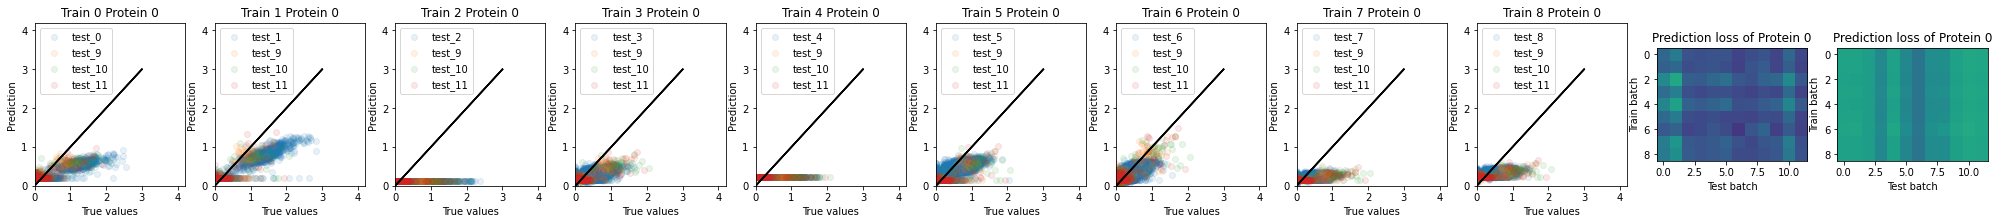

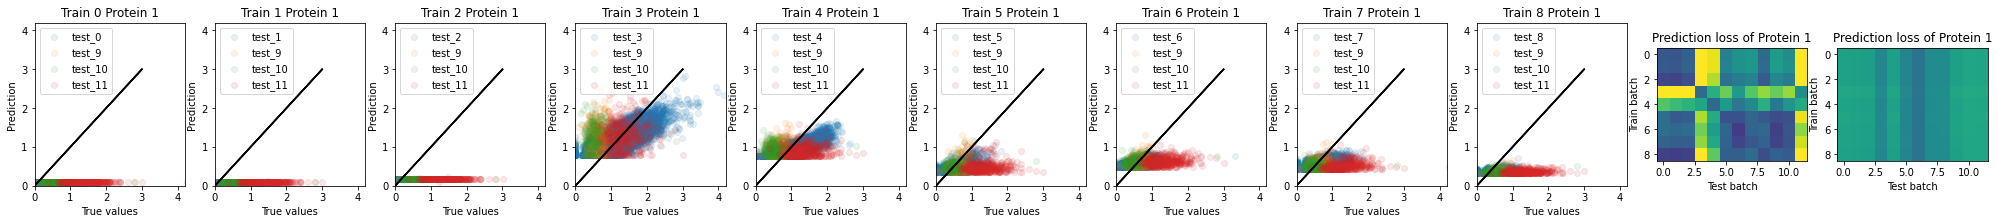

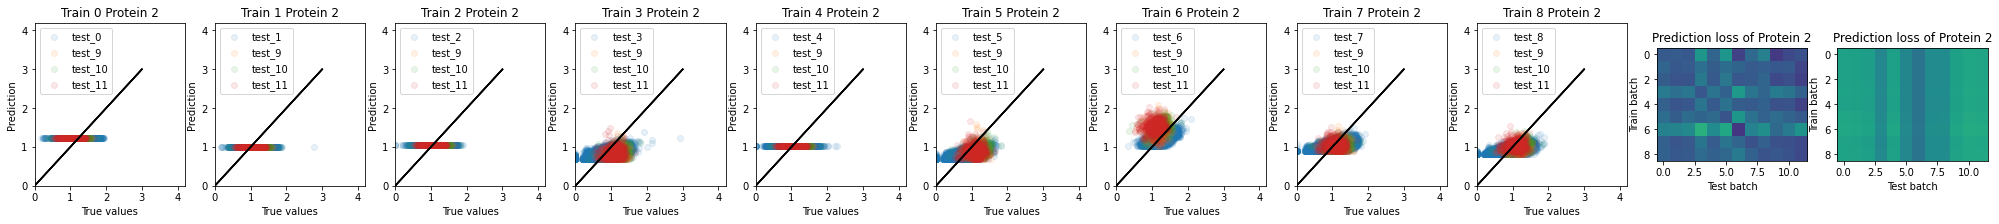

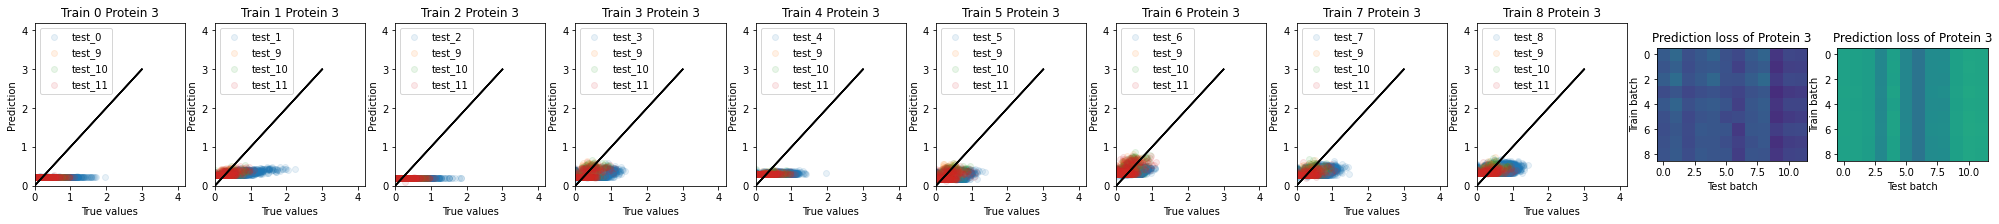

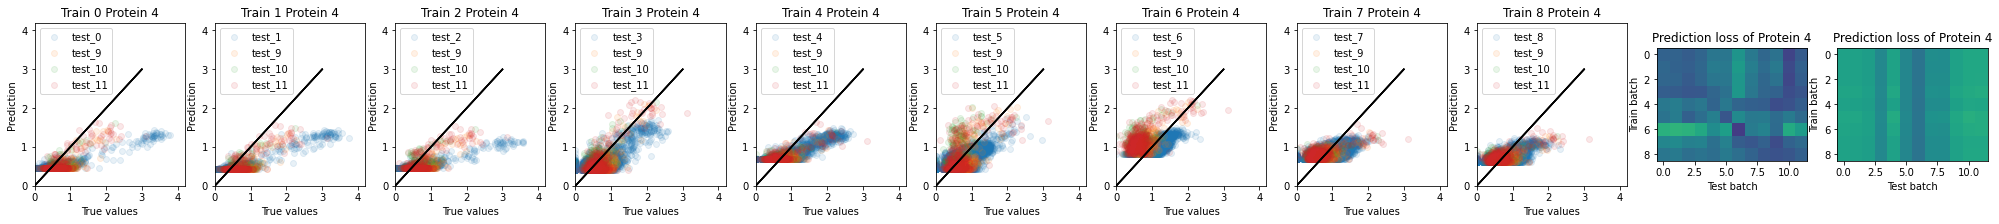

KeyboardInterrupt: 

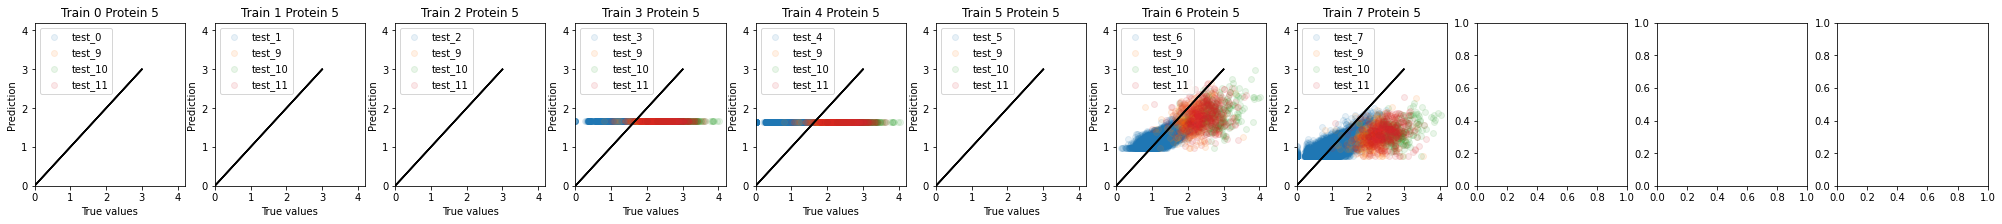

In [19]:
for j in range(134):
    
    pred_start = j
    pred_end = j + 1
    
    # if j % 5 == 0:
    #     print(f'Processing feature {pred_start}')
        
    pro_s1d1 = pro_s1d1_torch[:, pred_start:pred_end]
    pro_s1d2 = pro_s1d2_torch[:, pred_start:pred_end]
    pro_s1d3 = pro_s1d3_torch[:, pred_start:pred_end]
    pro_s2d1 = pro_s2d1_torch[:, pred_start:pred_end]
    pro_s2d4 = pro_s2d4_torch[:, pred_start:pred_end]
    pro_s2d5 = pro_s2d5_torch[:, pred_start:pred_end]
    pro_s3d1 = pro_s3d1_torch[:, pred_start:pred_end]
    pro_s3d6 = pro_s3d6_torch[:, pred_start:pred_end]
    pro_s3d7 = pro_s3d7_torch[:, pred_start:pred_end]
    pro_s4d1 = pro_s4d1_torch[:, pred_start:pred_end]
    pro_s4d8 = pro_s4d8_torch[:, pred_start:pred_end]
    pro_s4d9 = pro_s4d9_torch[:, pred_start:pred_end]
    
    pro_s1d1 = torch.cat([RNA_s1d1_raw_torch, pro_s1d1], 1)
    pro_s1d2 = torch.cat([RNA_s1d2_raw_torch, pro_s1d2], 1)
    pro_s1d3 = torch.cat([RNA_s1d3_raw_torch, pro_s1d3], 1)
    pro_s2d1 = torch.cat([RNA_s2d1_raw_torch, pro_s2d1], 1)
    pro_s2d4 = torch.cat([RNA_s2d4_raw_torch, pro_s2d4], 1)
    pro_s2d5 = torch.cat([RNA_s2d5_raw_torch, pro_s2d5], 1)
    pro_s3d1 = torch.cat([RNA_s3d1_raw_torch, pro_s3d1], 1)
    pro_s3d6 = torch.cat([RNA_s3d6_raw_torch, pro_s3d6], 1)
    pro_s3d7 = torch.cat([RNA_s3d7_raw_torch, pro_s3d7], 1)
    pro_s4d1 = torch.cat([RNA_s4d1_raw_torch, pro_s4d1], 1)
    pro_s4d8 = torch.cat([RNA_s4d8_raw_torch, pro_s4d8], 1)
    pro_s4d9 = torch.cat([RNA_s4d9_raw_torch, pro_s4d9], 1)
    
    RNA_batches = [RNA_s1d1_raw_torch, RNA_s1d2_raw_torch, RNA_s1d3_raw_torch, RNA_s2d1_raw_torch, RNA_s2d4_raw_torch,
                   RNA_s2d5_raw_torch, RNA_s3d1_raw_torch, RNA_s3d6_raw_torch, RNA_s3d7_raw_torch, RNA_s4d1_raw_torch,
                   RNA_s4d8_raw_torch, RNA_s4d9_raw_torch]
    pro_batches = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7, pro_s4d1, pro_s4d8, pro_s4d9]
    
    RNA_dataset = [RNA_s1d1_raw_torch, RNA_s1d2_raw_torch, RNA_s1d3_raw_torch, RNA_s2d1_raw_torch, RNA_s2d4_raw_torch,
                   RNA_s2d5_raw_torch, RNA_s3d1_raw_torch, RNA_s3d6_raw_torch, RNA_s3d7_raw_torch]
    
    pro_dataset = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5, pro_s3d1, pro_s3d6, pro_s3d7]
    emb_folder_names = ['s1d1_emb', 's1d2_emb', 's1d3_emb', 's2d1_emb', 's2d4_emb', 's2d5_emb', 's3d1_emb', 's3d6_emb', 's3d7_emb']
    
    train_ds_s1d1 = TensorDataset(RNA_dataset[0], pro_dataset[0])
    train_ds_s1d2 = TensorDataset(RNA_dataset[1], pro_dataset[1])
    train_ds_s1d3 = TensorDataset(RNA_dataset[2], pro_dataset[2])
    train_ds_s2d1 = TensorDataset(RNA_dataset[3], pro_dataset[3])
    train_ds_s2d4 = TensorDataset(RNA_dataset[4], pro_dataset[4])
    train_ds_s2d5 = TensorDataset(RNA_dataset[5], pro_dataset[5])
    train_ds_s3d1 = TensorDataset(RNA_dataset[6], pro_dataset[6])    
    train_ds_s3d6 = TensorDataset(RNA_dataset[7], pro_dataset[7])
    train_ds_s3d7 = TensorDataset(RNA_dataset[8], pro_dataset[8])       
        
    train_dl_s1d1 = DataLoader(train_ds_s1d1, batch_size= batch_size, shuffle=True)
    train_dl_s1d2 = DataLoader(train_ds_s1d2, batch_size= batch_size, shuffle=True)
    train_dl_s1d3 = DataLoader(train_ds_s1d3, batch_size= batch_size, shuffle=True)
    train_dl_s2d1 = DataLoader(train_ds_s2d1, batch_size= batch_size, shuffle=True)
    train_dl_s2d4 = DataLoader(train_ds_s2d4, batch_size= batch_size, shuffle=True)
    train_dl_s2d5 = DataLoader(train_ds_s2d5, batch_size= batch_size, shuffle=True)
    train_dl_s3d1 = DataLoader(train_ds_s3d1, batch_size= batch_size, shuffle=True)
    train_dl_s3d6 = DataLoader(train_ds_s3d6, batch_size= batch_size, shuffle=True)
    train_dl_s3d7 = DataLoader(train_ds_s3d7, batch_size= batch_size, shuffle=True)
    
    train_dls = [train_dl_s1d1, train_dl_s1d2, train_dl_s1d3, train_dl_s2d1, train_dl_s2d4, train_dl_s2d5, train_dl_s3d1, train_dl_s3d6, train_dl_s3d7]
    
    fig, ax = plt.subplots(1, 11, figsize = (35, 3))
    ax = ax.flatten()
    for i in range(len(RNA_dataset)):
        learning_rate = 0.001
        latent_dim = 4
        loss_fn = F.mse_loss
        batch_size = 50000

        loss_emb_plot = []
        loss_pro_plot = []

        def seed_everything(seed=1234):
            random.seed(seed)
            os.environ['PYTHONHASHSEED'] = str(seed)
            np.random.seed(seed)
            torch.manual_seed(seed)
            torch.backends.cudnn.deterministic = True

        seed_everything()

        model = Autoencoder()
        model = model.to(device)
        opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        fit(num_epochs, model, loss_fn, RNA_dataset[i], pro_dataset[i], emb_folder_names[i], i, j, ax)
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, ax = plt.subplots(3, 3, figsize = (12, 20))
ax = ax.flatten()
    
for i in range(9):
    ax[i].imshow(losses_encoder[i, :, :], aspect = 0.5, vmin = 0, vmax = 1)
    ax[i].set_title(f'Encoder loss of train batch {i}')
    ax[i].set_xlabel(f'Test batch')
    ax[i].set_ylabel(f'Protein prediction')

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, ax = plt.subplots(3, 3, figsize = (12, 20))
ax = ax.flatten()
    
for i in range(9):
    ax[i].imshow(losses_pro[i, :, :], aspect = 0.5, vmin = 0, vmax = 1)
    ax[i].set_title(f'Prediction loss of train batch {i}')
    ax[i].set_xlabel(f'Test batch')
    ax[i].set_ylabel(f'Protein prediction')

plt.show()

In [ ]:
figure, ax = plt.subplots(15, 9, figsize = (30, 45))
ax = ax.flatten()
    
for i in range(134):
    ax[i].imshow(losses_pro[:, i, :], vmin = 0, vmax = 1)
    ax[i].set_title(f'Prediction loss of Protein {i}')
    ax[i].set_xlabel(f'Test batch')
    ax[i].set_ylabel(f'Train batch')

plt.show()

In [ ]:
figure, ax = plt.subplots(3, 3, figsize = (12, 20))
ax = ax.flatten()
    
for i in range(9):
    ax[i].imshow(losses_total[i, :, :], aspect = 0.5, vmin = 0, vmax = 2)
    ax[i].set_title(f'Prediction loss of train batch {i}')
    ax[i].set_xlabel(f'Test batch')
    ax[i].set_ylabel(f'Protein prediction')

plt.show()